In [1]:
# Copyright 2017 Junghoon Lee
#   jhoon.chris@gmail.com

In [2]:
import pandas_datareader as pdr
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame, Panel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
from sp_ml import SpMl

In [10]:
class SpPolyReg(SpMl):
    'stock prediction by polynomial regression'
    
    def __init__(self):
        pass
        
    def preprocess_fetures(self):
        #print self.ivv.head()
        self.nm_ivv = self.ivv.copy(deep=True)
        self.nm_ivv['Adj Close'] = self.nm_ivv['Adj Close']/self.nm_ivv['Adj Close'][0]
        self.nm_ivv['Volume'] = self.nm_ivv['Volume']/self.nm_ivv['Volume'].mean()
        self.nm_ivv['Open'] = (self.nm_ivv['Close']-self.nm_ivv['Open'])/self.nm_ivv['Open']
        self.nm_ivv['High'] = (self.nm_ivv['High']-self.nm_ivv['Low'])/self.nm_ivv['Low']
        self.nm_ivv = self.nm_ivv.rename(columns = {'Open':'Change'})
        self.nm_ivv = self.nm_ivv.rename(columns = {'High':'Maxofday'})
        #print self.nm_ivv.head()

        #print self.gld.head()
        self.nm_gld = self.gld.copy(deep=True)
        self.nm_gld['Adj Close'] = self.nm_gld['Adj Close']/self.nm_gld['Adj Close'][0]
        self.nm_gld['Volume'] = self.nm_gld['Volume']/self.nm_gld['Volume'].mean()
        #print self.nm_gld.head()

        self.prices = self.nm_ivv['Adj Close']
        self.features = self.nm_ivv.drop(['Close', 'Low'], axis = 1)

        # Rolling Mean 10 days
        self.rm10_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=10)
        self.rm10_ivv_ = pd.DataFrame(self.rm10_ivv)
        self.rm10_ivv_ = self.rm10_ivv_.rename(columns = {'Adj Close':'RM10'})

        # Rolling Mean 20 days
        self.rm20_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=20)
        self.rm20_ivv_ = pd.DataFrame(self.rm20_ivv)
        self.rm20_ivv_ = self.rm20_ivv_.rename(columns = {'Adj Close':'RM20'})
        #print self.rm20_ivv_.tail()

        # Rolling Mean 40 days
        self.rm40_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=40)
        self.rm40_ivv_ = pd.DataFrame(self.rm40_ivv)
        self.rm40_ivv_ = self.rm40_ivv_.rename(columns = {'Adj Close':'RM40'})


        #print gld.head()
        self.gold = self.nm_gld.drop(['Open', 'High', 'Close', 'Low', 'Volume'], axis = 1)
        self.gold = self.gold.rename(columns = {'Adj Close':'GLD'})
        #print gold.head()
        #print "gold.dtypes", gold.dtypes

        self.features = self.features.join(self.gold, how='inner')
        self.features = self.features.join(self.rm10_ivv_, how='inner')
        self.features = self.features.join(self.rm20_ivv_, how='inner')
        self.features = self.features.join(self.rm40_ivv_, how='inner')

        print self.features.head()
        return

    
    def display_fetures(self):
        self.ivv[['Close','Adj Close', 'Open', 'High', 'Low']].plot(title='IVV price')
        plt.show()

        self.nm_ivv['Volume'].plot(title='nomalized IVV Volume')
        plt.show()

        self.gld[['Close','Adj Close', 'Open', 'High', 'Low']].plot(title='GLD price')
        plt.show()

        self.features[['Adj Close', 'RM20', 'RM40']].plot(title='nomalized IVV price, 20-days, 40-days mean')
        plt.show()
        return

    def do_regression(self):
        X_train = self.features[65:-50]
        y_train = self.prices[70:-45]
        X_test = self.features[-50:-5]
        y_test = self.prices[-45:]

        # Show the results of the split
        print "Training set has {} samples.".format(X_train.shape[0])
        print "Testing set has {} samples.".format(X_test.shape[0])

        #print X_train.head()
        #print X_train[:,1]
        #print y_train.head()

        for count, degree in enumerate([1, 2, 3, 4, 5, 6, 7, 8]):
            model = make_pipeline(PolynomialFeatures(degree), Ridge())
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print y_pred
            LR_result = pd.DataFrame(y_pred)
            LR_result.plot(title="degree %d" % degree)
            # The mean squared error
            print("degree : %d" % degree)
            print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
            # Explained variance score: 1 is perfect prediction
            print('Variance score: %.2f' % r2_score(y_test, y_pred))
    
        plt.show()         
        return
        
    def predict_nextweek(self):
        # Predict future 1-week
        X_train = self.features[65:-5]
        y_train = self.prices[70:]
        X_future = self.features[-5:]

        model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
        model.fit(X_train, y_train)

        # Make predictions using the testing set
        y_future = model.predict(X_future)

        print y_future

        start_predict_day = now+datetime.timedelta(1)
        end_predict_day = now+datetime.timedelta(5)
        start_predict_day = start_predict_day.strftime("%Y-%m-%d")
        end_predict_day = end_predict_day.strftime("%Y-%m-%d")

        days = pd.date_range(start_predict_day, end_predict_day, freq='D')

        df = pd.DataFrame({'Date': days, 'Prediction': y_future})
        df = df.set_index('Date')
        df['Prediction'] = df['Prediction'] * self.ivv['Adj Close'][0]
        print df 

        real_prices = self.prices[-10:] * self.ivv['Adj Close'][0]
        ax = real_prices.plot()
        df['Prediction'].plot(title='Linear Regression stock price forecasting', ax = ax)
        plt.show()
        return
    

2017-12-14
loading :  IVV from :  2016-01-01  to :  2017-12-14
loading :  GLD from :  2016-01-01  to :  2017-12-14
              Change  Maxofday  Adj Close    Volume       GLD  RM10  RM20  \
Date                                                                        
2016-01-04  0.002631  0.012125   1.000000  2.013542  1.000000   NaN   NaN   
2016-01-05  0.000544  0.009152   1.002079  1.424148  1.002819   NaN   NaN   
2016-01-06  0.002057  0.012338   0.988960  1.487585  1.017300   NaN   NaN   
2016-01-07 -0.006673  0.019684   0.965297  2.041959  1.031684   NaN   NaN   
2016-01-08 -0.016876  0.022283   0.954604  2.409782  1.027116   NaN   NaN   

            RM40  
Date              
2016-01-04   NaN  
2016-01-05   NaN  
2016-01-06   NaN  
2016-01-07   NaN  
2016-01-08   NaN  


/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=40,center=False).mean()


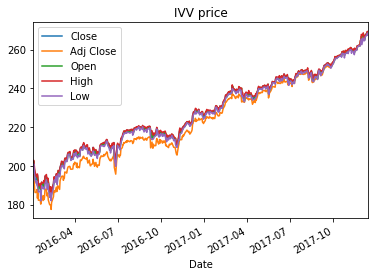

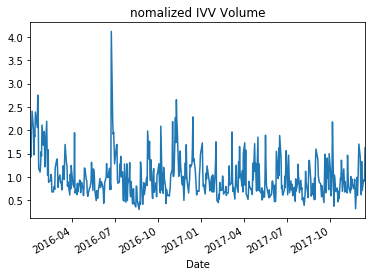

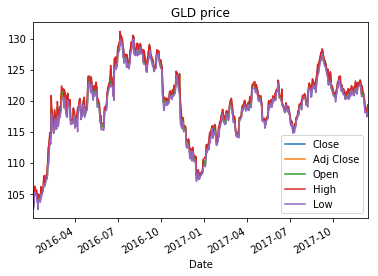

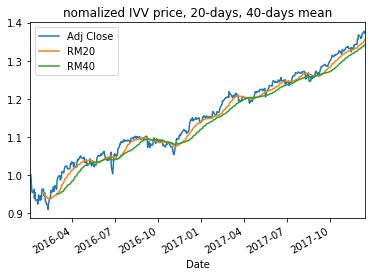

Training set has 378 samples.
Testing set has 45 samples.
[ 1.292452    1.29617876  1.29195396  1.29568391  1.29708267  1.29726737
  1.29819268  1.30022658  1.30124476  1.30224847  1.303615    1.30627322
  1.30708733  1.30865726  1.30880313  1.30966503  1.31201221  1.31276463
  1.31334556  1.31395132  1.31541853  1.31691674  1.3179442   1.32073073
  1.32110001  1.31990255  1.3203116   1.32098264  1.32158594  1.31919842
  1.32310431  1.32177738  1.32274778  1.32560646  1.32607802  1.32604384
  1.32817839  1.33175602  1.33361027  1.33988312  1.34121812  1.34159456
  1.34004036  1.34068441  1.34500618]
degree : 1
Mean squared error: 0.00
Variance score: -0.68
[ 1.31380674  1.32258063  1.30966394  1.31684467  1.31844052  1.31759949
  1.31837179  1.32110765  1.32157706  1.3222153   1.32464249  1.32791876
  1.32936423  1.33126097  1.33176974  1.33200928  1.33469832  1.3365622
  1.33620518  1.33623786  1.33886539  1.34043571  1.34173642  1.34794014
  1.3469487   1.34369042  1.34364762  1.3442

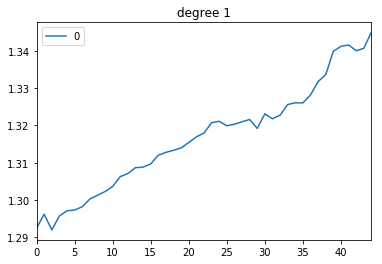

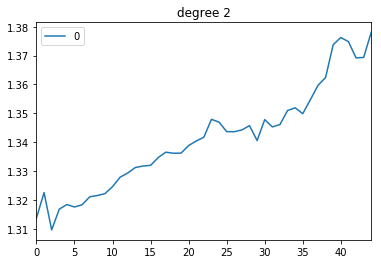

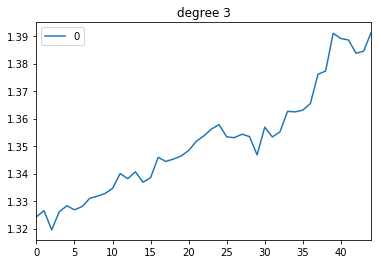

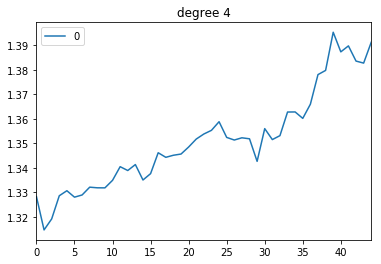

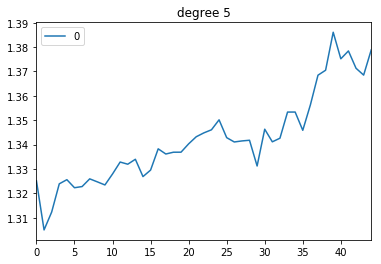

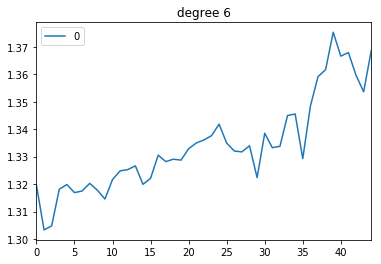

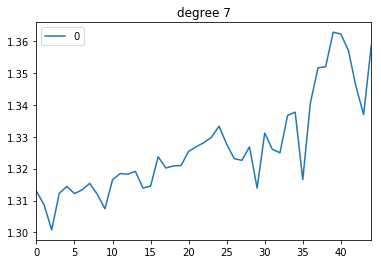

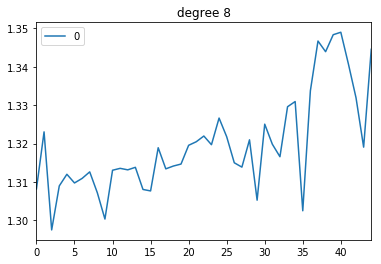

[ 1.37787421  1.3830132   1.38511743  1.38616931  1.3886268 ]
            Prediction
Date                  
2017-12-15  268.759163
2017-12-16  269.761541
2017-12-17  270.171978
2017-12-18  270.377151
2017-12-19  270.856492


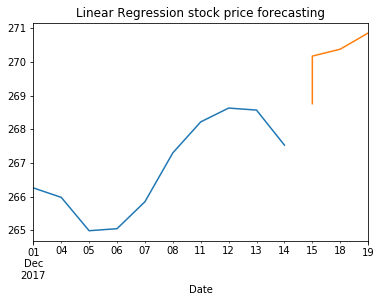

In [11]:
now = datetime.datetime.now()
end_date = now.strftime("%Y-%m-%d")
print end_date

pr_task = SpPolyReg()
pr_task.ivv = pr_task.get_input_feature('IVV', '2016-01-01', end_date)
pr_task.gld = pr_task.get_input_feature('GLD', '2016-01-01', end_date)

pr_task.preprocess_fetures()

pr_task.display_fetures()

pr_task.do_regression()

pr_task.predict_nextweek()